<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Intro to Machine Learning Based Strategies

## Importing the required libraries

The libraries that we are going to use are:
- `Yfinance` to download the daily prices from yahoo finance.
- `Numpy` and `Pandas` to manipulate the data.
- `Matplotlib` to create the charts


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt

### Graph Formating

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('figure', figsize=(10,6)) 



In [3]:
symbol = ["MSFT"]
rawdata = yf.download(symbol, start="2010-01-01", end="2019-12-31")
rawdata = pd.DataFrame(rawdata['Close'])
rawdata.columns = ['price']

[*********************100%***********************]  1 of 1 completed


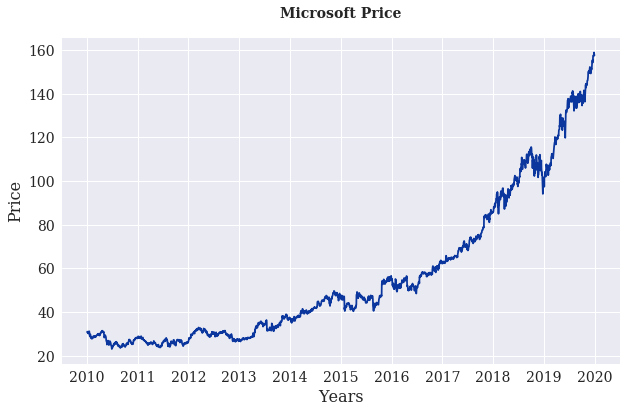

In [4]:
plt.figure()
plt.title('Microsoft Price',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Price')
plt.plot(rawdata, color='#0A369D');
# plt.savefig('price.png', facecolor='None')

In [5]:
LR = rawdata.copy()
LR['indx'] = np.arange(len(LR))

split = int(len(LR) * 0.8)
LR_train, LR_test = LR[:split], LR[split:]

X_test  = LR_test['indx'].values
X_train = LR_train['indx'].values
y_train = LR_train['price'].values

reg = np.polyfit(X_train, y_train, deg=1)
reg

array([ 0.02468901, 16.62908965])

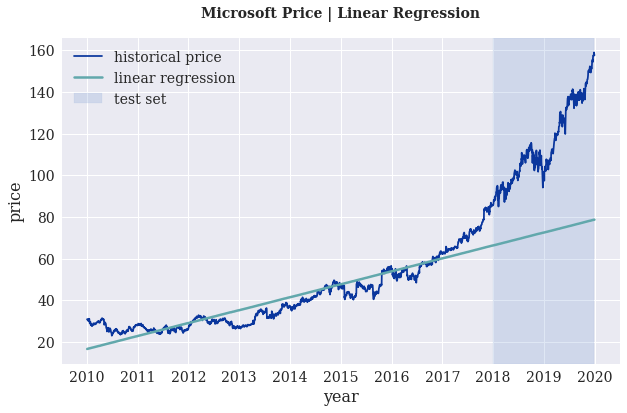

In [6]:
fig = plt.figure()
ax = plt.axes()
ax.plot(LR.index,LR['price'],label='historical price', color='#0A369D')
ax.plot(LR.index, np.polyval(reg, LR['indx']), lw=2.5,
         label='linear regression', color='#62a8ac')
ax.axvspan(LR.index[split], LR.index[len(LR)-1], alpha=0.25, color='#80A1D4', label='test set')
ax.set_title('Microsoft Price | Linear Regression',fontweight="bold", pad=20)
ax.set_xlabel('year')
ax.set_ylabel('price')
plt.legend(loc=0);
# plt.savefig('price_regression.png', facecolor='None')

In [7]:
lags = 5
cols = []
lagsR = rawdata.copy()

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    lagsR[col] = lagsR['price'].shift(lag)
    cols.append(col)
lagsR.dropna(inplace=True)

In [8]:
lagsR.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-11,30.270000,30.660000,30.450001,30.770000,30.959999,30.950001
2010-01-12,30.070000,30.270000,30.660000,30.450001,30.770000,30.959999
2010-01-13,30.350000,30.070000,30.270000,30.660000,30.450001,30.770000
2010-01-14,30.959999,30.350000,30.070000,30.270000,30.660000,30.450001
2010-01-15,30.860001,30.959999,30.350000,30.070000,30.270000,30.660000


In [9]:
a = lagsR[cols].corr()
a.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,1.000,0.999,0.999,0.999
lag_2,1.000,1.000,1.000,0.999,0.999
lag_3,0.999,1.000,1.000,1.000,0.999
lag_4,0.999,0.999,1.000,1.000,1.000
lag_5,0.999,0.999,0.999,1.000,1.000


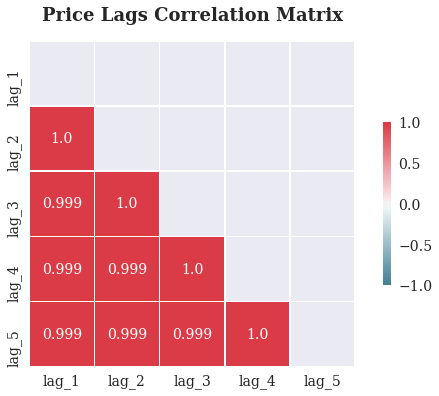

In [10]:
mask = np.triu(np.ones_like(a, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(a, mask=mask,  cmap=cmap,  annot=True,fmt=".3", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Price Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('price_corr.png', facecolor='None')

In [11]:
reg = np.linalg.lstsq(lagsR[cols], lagsR['price'],
                      rcond=None)[0]

In [12]:
lagsR['prediction'] = np.dot(lagsR[cols], reg)

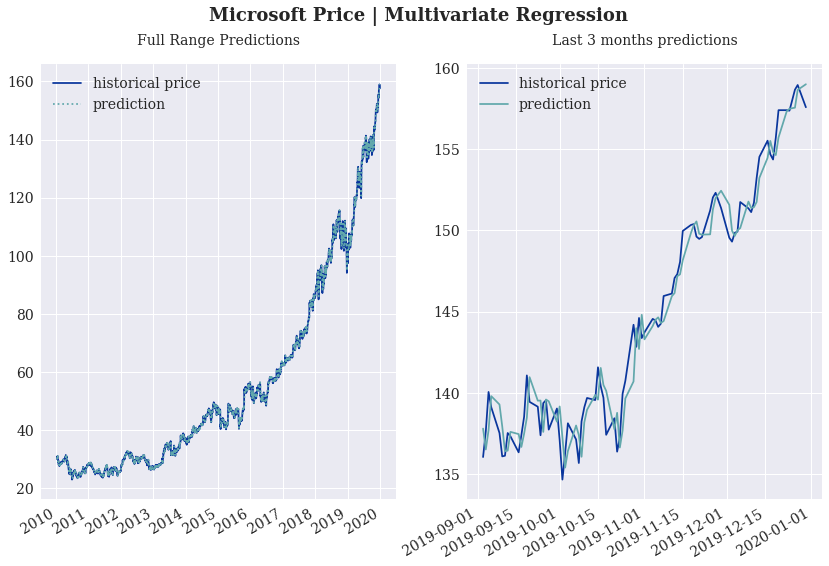

In [13]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.plot(lagsR.index, lagsR['price'], label='historical price', color='#0A369D')
plt.plot(lagsR.index, lagsR['prediction'], label='prediction', linestyle=':', color='#62a8ac')
plt.title('Full Range Predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');

plt.subplot(1,2,2)
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['price'].loc['2019-9-1':],
         label='historical price', color='#0A369D')
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['prediction'].loc['2019-9-1':],
         label='prediction', linestyle='-', color='#62a8ac')
plt.title('Last 3 months predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right')
plt.suptitle("Microsoft Price | Multivariate Regression",fontweight="bold");
# plt.savefig('price_multi.png', facecolor='None')

In [14]:
rets = rawdata.copy()
rets['returns'] = np.log(rets/rets.shift(1))

lags = 5
cols = []

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    rets[col] = rets['returns'].shift(lag)
    cols.append(col)
rets.dropna(inplace=True)

rets.head()

,price,returns,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,
2010-01-12,30.070000,-0.006629,-0.012802,0.006873,-0.010454,-0.006156,0.000323
2010-01-13,30.350000,0.009269,-0.006629,-0.012802,0.006873,-0.010454,-0.006156
2010-01-14,30.959999,0.019899,0.009269,-0.006629,-0.012802,0.006873,-0.010454
2010-01-15,30.860001,-0.003235,0.019899,0.009269,-0.006629,-0.012802,0.006873
2010-01-19,31.100000,0.007747,-0.003235,0.019899,0.009269,-0.006629,-0.012802


In [15]:
b = rets[cols].corr()
b.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,-0.035,-0.022,0.005,-0.037
lag_2,-0.035,1.000,-0.035,-0.022,0.005
lag_3,-0.022,-0.035,1.000,-0.035,-0.022
lag_4,0.005,-0.022,-0.035,1.000,-0.035
lag_5,-0.037,0.005,-0.022,-0.035,1.000


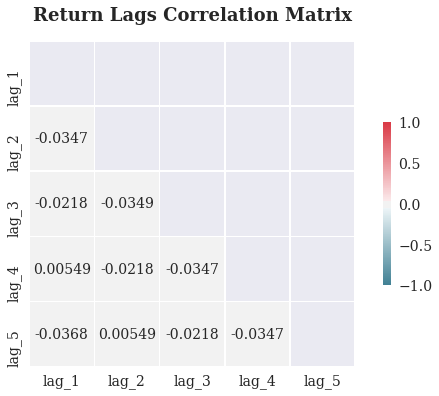

In [16]:
mask = np.triu(np.ones_like(b, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(b, mask=mask, cmap=cmap ,  annot=True ,fmt=".3",vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Return Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('returns_corr.png', facecolor='None')

In [17]:
reg = np.linalg.lstsq(rets[cols], rets['returns'],
                      rcond=None)[0]
reg

array([-0.03467407, -0.02135581,  0.00374165, -0.03650272, -0.05466607])

In [18]:
rets['prediction'] = np.dot(rets[cols], reg)

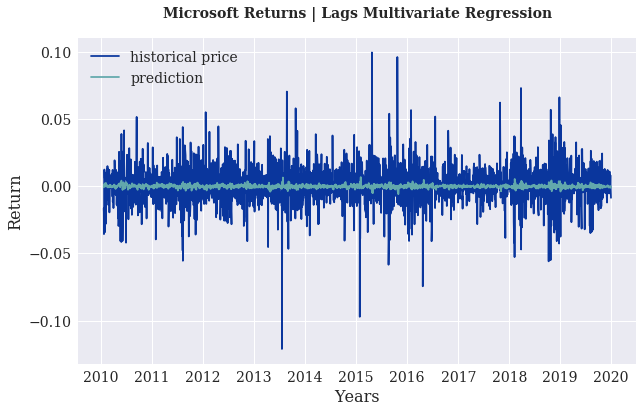

In [19]:
plt.figure()
plt.title('Microsoft Returns | Lags Multivariate Regression',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Return')
plt.plot(rets['returns'].iloc[lags:], label='historical price', color='#0A369D')
plt.plot(rets['prediction'].iloc[lags:], label='prediction', color='#62a8ac')
plt.legend(loc=0);
# plt.savefig('returns_multi.png', facecolor='None')

In [20]:
rets['prediction'] = np.sign(rets['prediction'])

In [21]:
hits = np.sign(rets['returns'] *
               rets['prediction']).value_counts()
hits

 1.0    1281
-1.0    1203
 0.0      25
dtype: int64

In [22]:
hits.values[0] / sum(hits)

0.5105619768832204

In [23]:
rets['strategy'] = rets['prediction'] * rets['returns']

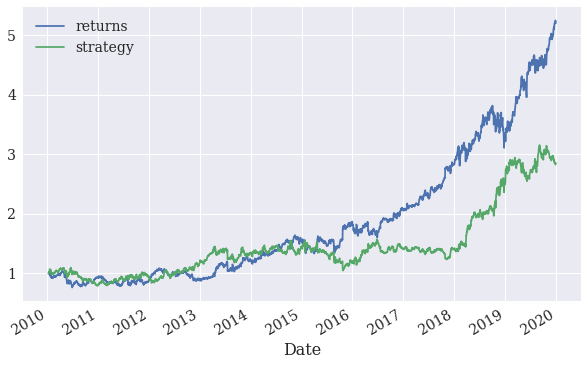

In [24]:
rets[['returns', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));

In [45]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model

cutoff = '2018-1-1'
train = rets[rets.index < cutoff].copy()
test = rets[rets.index >= cutoff].copy()

lm = linear_model.LogisticRegression(C=1e6, solver='lbfgs',
                                     multi_class='auto')
lm.fit(train[cols], np.sign(train['returns']))

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
test['prediction'] = lm.predict(test[cols])

In [47]:
test['prediction'].value_counts()

 1.0    346
-1.0    156
Name: prediction, dtype: int64

In [48]:
hits = np.sign(test['returns'].iloc[lags:] *
               test['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    273
-1.0    221
 0.0      3
dtype: int64

In [49]:
accuracy_score(test['prediction'],
               np.sign(test['returns']))

0.5537848605577689

In [50]:
test['strategy'] = test['prediction'] * test['returns']

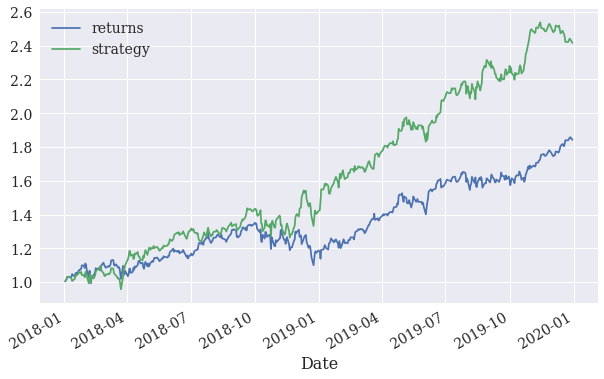

In [51]:
test[['returns', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));

## References

Inspired by the book *Artificial Intelligence for Finance* by Yves Hilpisch.

<img src="https://images-na.ssl-images-amazon.com/images/I/51VEL0RZbzL._SX379_BO1,204,203,200_.jpg" width="250" style="float:left">

and the program *Certificate in Python for Algorithmic Trading*

<img src="https://home.tpq.io/wp-content/uploads/2019/11/algo_broch_cov_shadow.png" width="250" style="float:left">

<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>